In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import keras
keras.__version__

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


'2.1.5'

# prepare image dataset

In [2]:
class Fer2013:

        
    def data_to_X_y(self):
        self.data = np.genfromtxt('fer2013.csv', delimiter=',', dtype=None)
        self.labels = self.data[1:,0].astype(np.int32) #[1:,0] - since [0:,0] would be with title of column
        self.image_buffer = self.data[1:,1]
        self.images = np.array([np.fromstring(image, np.float32, sep=' ') for image in self.image_buffer])
        self.usage = self.data[1:,2]
#         print(self.images.shape)
        
    def train_test_range(self):
    
        u = np.unique(self.usage)
        X_pr_test = []
        X_pu_test = []
        X_train = []

        for i in range(self.usage.shape[0]):
            if self.usage[i]  ==  u[2]:
                self.Training  = i
            elif self.usage[i]  ==  u[1]:
                self.PublicTest = i
            elif self.usage[i]  ==  u[0]:
                self.PrivateTest = i
        print("Training: ", self.Training, "PublicTest: ", self.PublicTest, "PrivateTest: ", self.PrivateTest)
#         return Training, PublicTest, PrivateTest
    
    def split_images(self, floor, roof):
        return self.images[floor:roof,:].reshape(-1, 48,48)

    def split_labels(self, floor, roof):
        return self.labels[floor:roof]
    
    def load_data(self):
        self.data_to_X_y()
        self.train_test_range()
#         print(self.images.shape)
#         print(self.Training)
        X_train = self.images[0:self.Training,:]#.reshape(-1, 48,48)
#         print(X_train.shape)
        X_train = self.split_images( 0, self.Training)
        X_publicTest = self.split_images(self.Training+1, self.PublicTest)
        X_privateTest = self.split_images(self.PublicTest+1, self.PrivateTest)
        
        y_train = self.split_labels(0, self.Training)
        y_publicTest = self.split_labels(self.Training+1, self.PublicTest)
        y_privateTest = self.split_labels(self.PublicTest+1, self.PrivateTest)
        
        return X_train, y_train, X_publicTest, y_publicTest, X_privateTest, y_privateTest

In [3]:
fer2013 = Fer2013()

In [4]:
X_train, y_train, X_publicTest, y_publicTest, X_privateTest, y_privateTest = fer2013.load_data() #, , y_privateTest, X_publicTest

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  """


Training:  28708 PublicTest:  32297 PrivateTest:  35886


In [5]:
moods = {
    0: 'ANGRY',
    1: 'DISGUST',
    2: 'FEAR',
    3: 'HAPPY',
    4: 'SAD',
    5: 'SURPRISE',
    6: 'NEUTRAL'}
moods = {
    0: 'ANGRY',
    1: 'FEAR',
    2: 'HAPPY',
    3: 'SAD',
    4: 'SURPRISE',
    5: 'NEUTRAL'}
a = 1
print(moods[a])

FEAR


In [6]:
def combine_anger_disgust(array):

    for row in np.arange(len(array)):
        if array[row] == 0:
            array[row] = 1
    return array -1


In [7]:
y_train = combine_anger_disgust(y_train)
y_publicTest = combine_anger_disgust(y_publicTest)
y_privateTest = combine_anger_disgust(y_privateTest)

Text(0.5,1,'HAPPY')

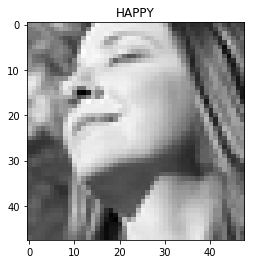

In [8]:
plt.imshow(X_train[1020], cmap = 'gray')
plt.title(moods[y_train[1020]])

Text(0.5,1,'NEUTRAL')

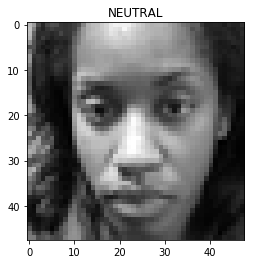

In [9]:
plt.imshow(X_privateTest[1019], cmap = 'gray')
plt.title(moods[y_privateTest[1019]])

Text(0.5,1,'ANGRY')

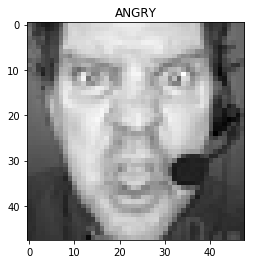

In [10]:
plt.imshow(X_publicTest[1021], cmap = 'gray')
plt.title(moods[y_publicTest[1021]])

In [11]:
X_train = X_train.reshape(-1, 48, 48, 1).astype('float32')/255.0
X_privateTest = X_privateTest.reshape(-1, 48, 48, 1).astype('float32')/255.0
X_publicTest = X_publicTest.reshape(-1, 48, 48, 1).astype('float32')/255.0


from keras.utils.np_utils import to_categorical
y_train_cat = to_categorical(y_train)
y_privateTest_cat = to_categorical(y_privateTest)
y_publicTest_cat = to_categorical(y_publicTest)


# BUILD MODEL

In [ ]:
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.advanced_activations import ELU
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K
from keras import optimizers
from keras.callbacks import ModelCheckpoint

In [ ]:
checkpointer = ModelCheckpoint(filepath="weights.hdf5",
                               verbose=1, save_best_only=True)

In [ ]:
model = Sequential()
inputShape = (48, 48, 1)
chanDim = -1

# if we are using "channels first", update the input shape
# and channels dimension
if K.image_data_format() == "channels_first":
    inputShape = (48, 48, 1)
    chanDim = 1

# Block #1: first CONV => RELU => CONV => RELU => POOL
# layer set
model.add(Conv2D(32, (3, 3), padding="same",
    kernel_initializer="he_normal", input_shape=inputShape))
model.add(ELU())
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(32, (3, 3), kernel_initializer="he_normal",
padding="same"))
model.add(ELU())
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Block #2: second CONV => RELU => CONV => RELU => POOL
# layer set
model.add(Conv2D(64, (3, 3), kernel_initializer="he_normal",
    padding="same"))
model.add(ELU())
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), kernel_initializer="he_normal",
    padding="same"))
model.add(ELU())
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Block #3: third CONV => RELU => CONV => RELU => POOL
# layer set
model.add(Conv2D(128, (3, 3), kernel_initializer="he_normal",
    padding="same"))
model.add(ELU())
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), kernel_initializer="he_normal",
    padding="same"))
model.add(ELU())
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

    # Block #4: first set of FC => RELU layers
model.add(Flatten())
model.add(Dense(64, kernel_initializer="he_normal"))
model.add(ELU())
model.add(BatchNormalization())
model.add(Dropout(0.5))

    # Block #6: second set of FC => RELU layers
model.add(Dense(64, kernel_initializer="he_normal"))
model.add(ELU())
model.add(BatchNormalization())
model.add(Dropout(0.5))

    # Block #7: softmax classifier
model.add(Dense(6, kernel_initializer="he_normal"))
model.add(Activation("softmax"))

opt = optimizers.Adam(lr=1e-3)

hist = model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [ ]:
# callbacks=callbacks, verbose=1
hist = model.fit(X_train, y_train_cat, callbacks=[checkpointer], batch_size=128, epochs = 40, verbose=1, validation_data= (X_publicTest, y_publicTest_cat) )

In [ ]:
test_accuracy = model.evaluate(X_privateTest, y_privateTest_cat)[1]
test_accuracy

In [ ]:
model.save('emotion_model.h5')

In [ ]:
plt.style.use('ggplot')
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.legend(['Trainig', 'Testing'])
plt.title('Accuracy')
plt.xlabel('Epochs')